In [1]:
import pandas as pd
import csv

In [3]:
# loading dataset
business_path = "../../city_filter/businesses_Indianapolis.csv"
business_df = pd.read_csv(business_path, encoding='utf-8')

## 1. 直接处理

In [208]:
# 删去is_open=0的行
business_df = business_df[business_df['is_open'] == 1]
# 只保留需要的列, 删去name,address,city,state,postal_code,latitude,longitude
business_df = business_df[['business_id', 'stars', 'review_count', 'attributes', 'categories']]
# 去掉有缺失项的行
business_df = business_df.dropna()

In [209]:
# 对stars, review_count标准化
business_df['stars'] = (business_df['stars'] - business_df['stars'].mean()) / business_df['stars'].std()
business_df['review_count'] = (business_df['review_count'] - business_df['review_count'].mean()) / business_df['review_count'].std()

## 2. 处理属性列

In [210]:
# 清洗attributes
import re
import ast

def clean_attribute_string(attr_str):
    if not isinstance(attr_str, str) or attr_str == 'None':
        return {}

    try:
        # Step 1: 替换 u'xxx' → 'xxx'
        attr_str = re.sub(r"u'([^']*)'", r"'\1'", attr_str)

        # Step 2: 替换布尔值和 None 为字符串
        attr_str = attr_str.replace("True", "'True'")
        attr_str = attr_str.replace("False", "'False'")
        attr_str = attr_str.replace("None", "'None'")

        # Step 3: 替换 ""'xxx'"" → 'xxx'（双引号包裹单引号）
        attr_str = re.sub(r'""\'(.*?)\'""', r"'\1'", attr_str)

        # Step 4: 替换 "'xxx'" → 'xxx'（双引号包裹单引号的另一个写法）
        attr_str = re.sub(r'"\'(.*?)\'"', r"'\1'", attr_str)

        # Step 5: 替换 ''xxx'' → 'xxx'（双单引号）
        attr_str = re.sub(r"''([^']*?)''", r"'\1'", attr_str)

        # Step 6: 使用 ast 解析主结构
        attr_dict = ast.literal_eval(attr_str)

        # Step 7: 尝试解析嵌套字符串（如 BusinessParking）
        for key, value in list(attr_dict.items()):
            if isinstance(value, str) and re.match(r"^\{.*\}$", value.strip()):
                try:
                    attr_dict[key] = ast.literal_eval(value)
                except:
                    pass

        return attr_dict

    except Exception as e:
        print(f"[解析失败] {e}\n原始字符串: {attr_str}")
        return {}

In [211]:
def flatten_attributes(attr_dict, parent_key=''):
    """
    将嵌套属性 dict 展平成平铺形式，所有 key 转为小写，value 为字符串小写格式。
    如 {'BusinessParking': {'garage': 'True'}} → {'businessparking_garage': 'true'}
    """
    flat = {}

    for k, v in attr_dict.items():
        new_key = f"{parent_key}_{k}".lower() if parent_key else k.lower()

        if isinstance(v, dict):
            # 递归展开
            flat.update(flatten_attributes(v, new_key))
        else:
            # 安全转换为字符串 + 小写
            flat[new_key] = str(v).strip().lower()

    return flat

In [ ]:
# 假设你有一列叫 'attributes'
business_df['parsed_attributes'] = business_df['attributes'].apply(clean_attribute_string)
business_df['flat_attributes'] = business_df['parsed_attributes'].apply(flatten_attributes)
# 去掉attributes列
business_df.drop(columns=['attributes'], inplace=True)
business_df.to_csv('businesses_Indianapolis_cleaned.csv')


# 构造成 DataFrame
attr_df = pd.json_normalize(business_df['flat_attributes'])

# 查看 top N 高频属性
top_attrs = attr_df.notnull().sum().sort_values(ascending=False).head(30).index.tolist()
attr_df_top = pd.DataFrame()
attr_df_top['business_id'] = business_df['business_id']
for attr in top_attrs:
    attr_df_top[attr] = attr_df[attr]

attr_df_top.reset_index(drop=True, inplace=True)
attr_df_top

,business_id,businessacceptscreditcards,businessparking_garage,businessparking_street,businessparking_validated,businessparking_lot,businessparking_valet,restaurantspricerange2,bikeparking,restaurantstakeout,...,ambience_divey,ambience_trendy,ambience_classy,ambience_casual,ambience_upscale,restaurantsgoodforgroups,caters,alcohol,noiselevel,restaurantsattire
0,il_Ro8jwPlHresjw9EGmBg,true,none,false,none,true,false,1,false,true,...,none,none,none,true,none,true,NaN,none,NaN,casual
1,qhDdDeI3K4jy2KyzwFN53w,true,false,false,false,true,false,2,false,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,kfNv-JZpuN6TVNSO6hHdkw,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,true,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,x1mhq4IpWctQOBM06dU8vg,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,seKihQKpGGnCeLuELRQPSQ,true,false,false,false,true,false,2,false,true,...,false,none,false,true,false,true,false,full_bar,average,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,2f1ZnZg7730yChhV24ARJw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5331,AM7O0cwkxm6w_e0Q7-f9FQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5332,Gi1QPLu_y8rLS3uTN9Z_VA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5333,fn3ybdsRSrIDpKZTsRuAWg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. 处理类别列

In [213]:
# 处理categories
from sklearn.feature_extraction.text import TfidfVectorizer
# 替换缺失值为空字符串
business_df['categories'] = business_df['categories'].fillna('')

# 使用逗号空格分割的类别字符串作为“文档”
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(', '), lowercase=True, max_features=50)
category_tfidf_matrix = vectorizer.fit_transform(business_df['categories'])

# 得到 TF-IDF 得分矩阵（稀疏）
tfidf_df = pd.DataFrame()
tfidf_df['business_id'] = business_df['business_id'].values
tfidf_df[vectorizer.get_feature_names_out()] = category_tfidf_matrix.toarray()

# 输出
tfidf_df

/home/dzz/miniconda3/envs/dzz/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,business_id,active life,american (new),american (traditional),apartments,arts & entertainment,auto repair,automotive,bakeries,bars,...,professional services,real estate,restaurants,salad,sandwiches,seafood,shopping,specialty food,tires,venues & event spaces
0,il_Ro8jwPlHresjw9EGmBg,0.000000,0.000000,0.635275,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.34357,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,qhDdDeI3K4jy2KyzwFN53w,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
2,kfNv-JZpuN6TVNSO6hHdkw,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,1.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,x1mhq4IpWctQOBM06dU8vg,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.432330,0.0,0.0,0.0
4,seKihQKpGGnCeLuELRQPSQ,0.000000,0.543771,0.481452,0.0,0.0,0.0,0.0,0.0,0.458111,...,0.000000,0.0,0.26038,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,2f1ZnZg7730yChhV24ARJw,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5331,AM7O0cwkxm6w_e0Q7-f9FQ,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5332,Gi1QPLu_y8rLS3uTN9Z_VA,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5333,fn3ybdsRSrIDpKZTsRuAWg,0.416419,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.532986,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## 4. 构建综合评分体系

In [214]:
# 得到属性值域
def get_attribute_domains(attr_df):
    """
    获取属性值域
    :param attr_df: 属性 DataFrame
    :return: 属性值域字典
    """
    domains = {}
    for col in attr_df.columns:
        if col == 'business_id':
            continue
        unique_values = attr_df[col].dropna().unique()
        domains[col] = unique_values.tolist()
    return domains
# 获取属性值域
attribute_domains = get_attribute_domains(attr_df_top)
attribute_domains

{'businessacceptscreditcards': ['true', 'none', 'false'],
 'businessparking_garage': ['none', 'false', 'true'],
 'businessparking_street': ['false', 'true', 'none'],
 'businessparking_validated': ['none', 'false', 'true'],
 'businessparking_lot': ['true', 'false', 'none'],
 'businessparking_valet': ['false', 'true'],
 'restaurantspricerange2': ['1', '2', '3', '4', 'none'],
 'bikeparking': ['false', 'true', 'none'],
 'restaurantstakeout': ['true', 'false', 'none'],
 'restaurantsdelivery': ['true', 'false', 'none'],
 'wifi': ['no', 'free', 'paid', 'none'],
 'goodforkids': ['true', 'false', 'none'],
 'outdoorseating': ['false', 'true', 'none'],
 'hastv': ['true', 'false'],
 'restaurantsreservations': ['false', 'true', 'none'],
 'byappointmentonly': ['false', 'true'],
 'ambience_hipster': ['none', 'false', 'true'],
 'ambience_romantic': ['false', 'none', 'true'],
 'ambience_touristy': ['none', 'false', 'true'],
 'ambience_intimate': ['none', 'false', 'true'],
 'ambience_divey': ['none', 'f

In [215]:
# 得到属性评分体系
attribute_score_map = {
    # 布尔型
    'true': 1.0,
    'false': -0.5,
    'none': 0.0,

    # WiFi
    'free': 1.0,
    'paid': 0.5,
    'no': -0.5,

    # alcohol
    'none': 0.0,
    'beer_and_wine': 0.5,
    'full_bar': 1.0,

    # noise level
    'quiet': 1.0,
    'average': 0.5,
    'loud': -0.5,
    'very_loud': -1.0,

    # attire
    'casual': 1.0,
    'dressy': 0.5,
    'formal': 0.0,
    
    # price range (string number)
    '1': 1.0,
    '2': 0.5,
    '3': 0.0,
    '4': -0.5,
}

In [216]:
def score_attribute_row(row, score_map):
    score = 0
    for val in row:
        if pd.isna(val): continue
        val_str = str(val).strip().lower()
        score += score_map.get(val_str, 0.0)
    return score

attr_df_top['attr_score'] = attr_df_top.drop(columns=['business_id']).apply(
    lambda row: score_attribute_row(row, attribute_score_map), axis=1
)
attr_df_top.to_csv('businesses_Indianapolis_top_attributes.csv', index=False)
attr_df_top

,business_id,businessacceptscreditcards,businessparking_garage,businessparking_street,businessparking_validated,businessparking_lot,businessparking_valet,restaurantspricerange2,bikeparking,restaurantstakeout,...,ambience_trendy,ambience_classy,ambience_casual,ambience_upscale,restaurantsgoodforgroups,caters,alcohol,noiselevel,restaurantsattire,attr_score
0,il_Ro8jwPlHresjw9EGmBg,true,none,false,none,true,false,1,false,true,...,none,none,true,none,true,NaN,none,NaN,casual,6.5
1,qhDdDeI3K4jy2KyzwFN53w,true,false,false,false,true,false,2,false,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,kfNv-JZpuN6TVNSO6hHdkw,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,true,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5
3,x1mhq4IpWctQOBM06dU8vg,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
4,seKihQKpGGnCeLuELRQPSQ,true,false,false,false,true,false,2,false,true,...,none,false,true,false,true,false,full_bar,average,casual,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,2f1ZnZg7730yChhV24ARJw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5331,AM7O0cwkxm6w_e0Q7-f9FQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5332,Gi1QPLu_y8rLS3uTN9Z_VA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5333,fn3ybdsRSrIDpKZTsRuAWg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [217]:
tfidf_df['cat_score'] = tfidf_df.drop(columns=['business_id']).sum(axis=1)
tfidf_df.to_csv('businesses_Indianapolis_categories.csv', index=False)
tfidf_df

,business_id,active life,american (new),american (traditional),apartments,arts & entertainment,auto repair,automotive,bakeries,bars,...,real estate,restaurants,salad,sandwiches,seafood,shopping,specialty food,tires,venues & event spaces,cat_score
0,il_Ro8jwPlHresjw9EGmBg,0.000000,0.000000,0.635275,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.34357,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.670499
1,qhDdDeI3K4jy2KyzwFN53w,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000
2,kfNv-JZpuN6TVNSO6hHdkw,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000
3,x1mhq4IpWctQOBM06dU8vg,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.432330,0.0,0.0,0.0,1.692475
4,seKihQKpGGnCeLuELRQPSQ,0.000000,0.543771,0.481452,0.0,0.0,0.0,0.0,0.0,0.458111,...,0.0,0.26038,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.185136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,2f1ZnZg7730yChhV24ARJw,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.381861
5331,AM7O0cwkxm6w_e0Q7-f9FQ,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.381861
5332,Gi1QPLu_y8rLS3uTN9Z_VA,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000
5333,fn3ybdsRSrIDpKZTsRuAWg,0.416419,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.208772


In [218]:
# 给出新的business_features的df
business_features_df = pd.DataFrame()
business_features_df['business_id'] = business_df['business_id']
business_features_df['stars'] = business_df['stars']
business_features_df['review_count'] = business_df['review_count']
business_features_df['attr_score'] = attr_df_top['attr_score']
business_features_df['cat_score'] = tfidf_df['cat_score']
business_features_df.to_csv('businesses_Indianapolis_features.csv', index=False)

## 5. 可视化分布

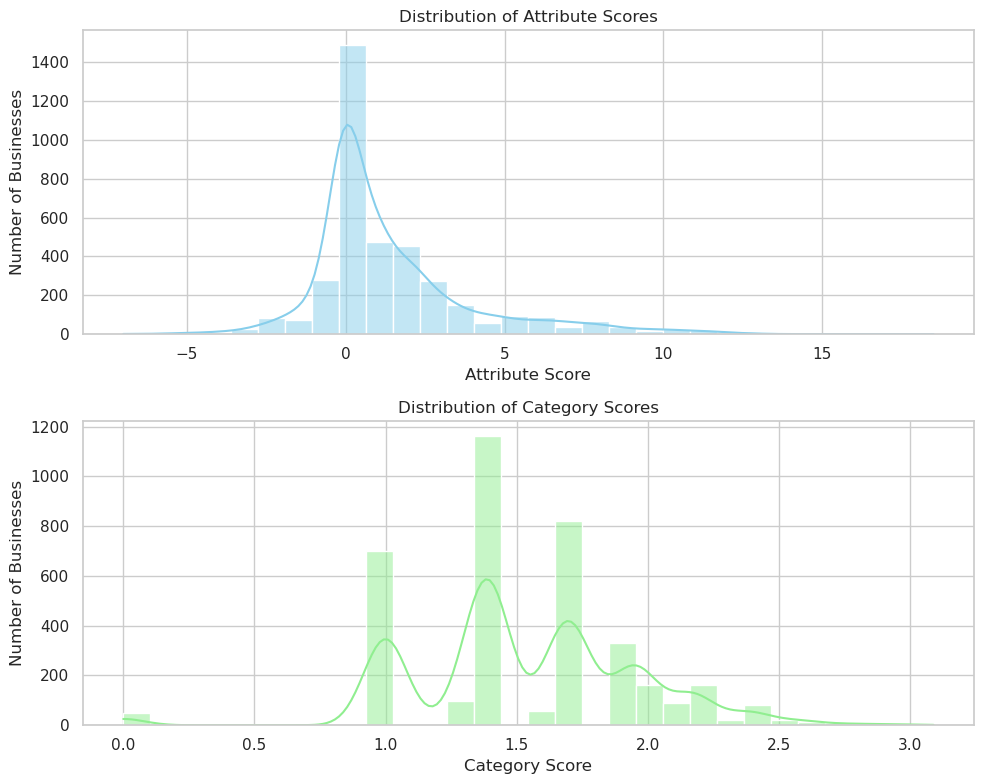

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns

# 确保用 seaborn 样式
sns.set_theme(style='whitegrid')

# 创建 2 行 1 列的子图
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=False)

# 第一个图：属性得分分布
sns.histplot(business_features_df['attr_score'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Attribute Scores')
axes[0].set_xlabel('Attribute Score')
axes[0].set_ylabel('Number of Businesses')

# 第二个图：类别得分分布
sns.histplot(business_features_df['cat_score'], bins=30, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of Category Scores')
axes[1].set_xlabel('Category Score')
axes[1].set_ylabel('Number of Businesses')

plt.tight_layout()
# 保存图像
plt.savefig('business_scores_distribution.png', dpi=300)
plt.show()

            